## ANN Non-Linear Regression - tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Input
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("car_purchasing.csv", encoding="latin1")

data.head()

,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


In [3]:
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
cols_ohe = ['country']

ohe_encoded = ohe.fit_transform(data[cols_ohe])

ohe_df = pd.DataFrame(
    ohe_encoded,
    columns=ohe.get_feature_names_out(cols_ohe),
    index = data.index
)

df = pd.concat([data.drop(columns = cols_ohe), ohe_df],
               axis = 1)
df.head()

,gender,age,annual Salary,credit card debt,net worth,car purchase amount,country_Algeria,country_American Samoa,country_Andorra,country_Angola,...,country_Venezuela,country_Viet Nam,"country_Virgin Islands, British","country_Virgin Islands, United States",country_Wallis and Futuna,country_Western Sahara,country_Yemen,country_Zimbabwe,country_marlal,country_Åland Islands
0,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X = df.drop(columns = ['car purchase amount'])
y = df['car purchase amount'] / 1000

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=13)

num_cols = ['age', 'annual Salary', 'credit card debt', 'net worth']

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [5]:
model = Sequential([
    Input(shape = (X_train.shape[1],)),
    Dense(128),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.3),
    Dense(64),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.3),
    Dense(1)
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer = opt,
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()] 
)

es = EarlyStopping(
    monitor = 'val_loss',
    patience = 20,
    restore_best_weights = True
)

In [6]:
hist_mod = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 2000,
    batch_size = 128,
    callbacks = [es],
    verbose = 0
)

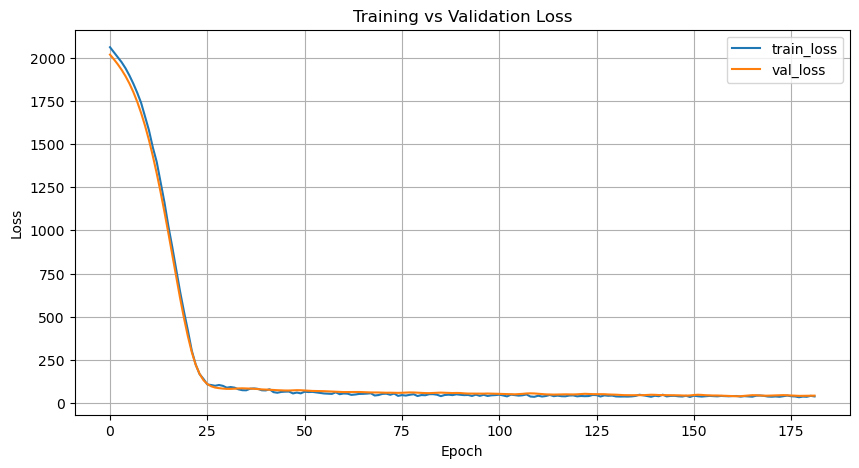

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(hist_mod.history["loss"], label="train_loss")
ax.plot(hist_mod.history["val_loss"], label="val_loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training vs Validation Loss")
ax.legend()
ax.grid(True)

plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


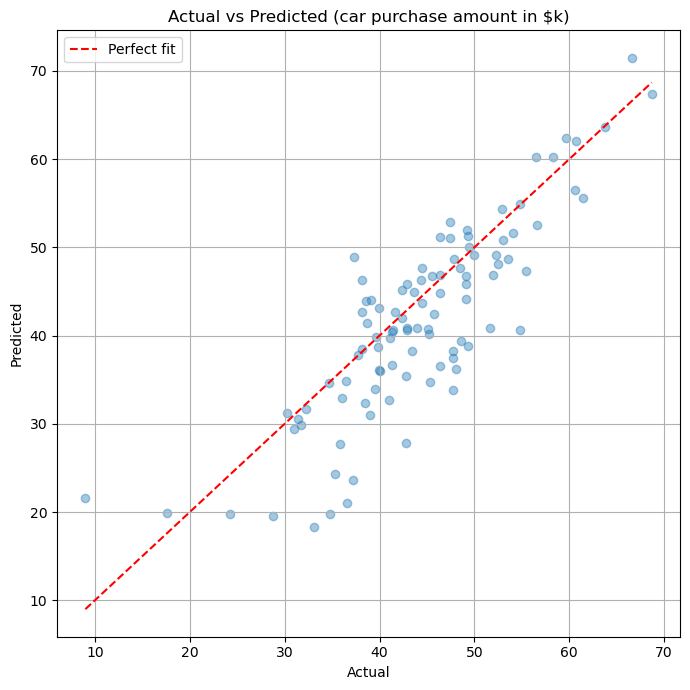

In [8]:
y_pred = model.predict(X_test).squeeze()
y_true = y_test.values

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(y_true, y_pred, alpha=0.4)
ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect fit')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs Predicted (car purchase amount in $k)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()